# Evaluate success of events

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import io
from PIL import Image

from Functions import *

def MAPE(Y_actual,Y_Predicted):
    try:
        mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    except:
        mape = np.nan
    return mape

## Case studies

22nd February 2015 - 'White Night' - actually from 7pm on the 21st until 7am on the 22nd  
16th July 2021 - lockdown announced

### Read in Melbourne sensor location spatial data

In [7]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

### Define parameters

In [8]:
buffer_size_m = 400
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Read in predictions from running model with CV (in other script)

In [9]:
predictions = pd.read_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m))["0"]
len(predictions)

4129082

### Reformat predictions as a dataframe

In [10]:
# Get all relevant data in one dataframe
predictions_df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions),
                 'Error':Yfull-predictions, 'datetime':data_time_columns['datetime']})
# Add hour of week variable
predictions_df['hour_of_week'] = predictions_df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
predictions_df=predictions_df.sort_values(by=['Weekday', 'Hour'])
# Add percentage increase column
predictions_df['Percentage_Increase']= ((predictions_df['Real_vals'] - predictions_df['Predictions']) / abs(predictions_df['Predictions'])) * 100
# Convert date time column to correct format
predictions_df["datetime"]  = pd.to_datetime(predictions_df["datetime"] , errors='coerce')

### Find hours with biggest error

In [11]:
predictions_df.nlargest(10, 'Error')

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Increase
813830,50.46,2265,5,6,28,2214.54,2214.54,2015-04-25 05:00:00,w6_h5,4388.703924
3647131,95.97,2302,22,3,57,2206.03,2206.03,2021-12-29 22:00:00,w3_h22,2298.666250
763189,60.05,2265,4,7,28,2204.95,2204.95,2015-02-22 04:00:00,w7_h4,3671.856786
763165,50.78,2246,4,7,7,2195.22,2195.22,2015-02-22 04:00:00,w7_h4,4323.001182
3635919,121.13,2296,22,3,57,2174.87,2174.87,2021-12-22 22:00:00,w3_h22,1795.484191
1437209,174.43,2298,22,1,29,2123.57,2123.57,2017-03-13 22:00:00,w1_h22,1217.433928
2390728,187.52,2303,0,7,28,2115.48,2115.48,2019-08-25 00:00:00,w7_h0,1128.135666
1547318,120.89,2234,14,3,12,2113.11,2113.11,2017-07-19 14:00:00,w3_h14,1747.960956
61985,68.03,2179,6,7,5,2110.97,2110.97,2011-06-12 06:00:00,w7_h6,3102.998677
2115399,164.57,2271,1,2,45,2106.43,2106.43,2019-01-01 01:00:00,w2_h1,1279.959895


## Get data for just one day (e.g. Anzac Day 2015)

In [97]:
predictions_df['datetime']
mask = (predictions_df['datetime'] > '2021-02-08') & (predictions_df['datetime']<= '2021-02-26')

anzac_day = predictions_df.loc[mask]
anzac_day.sort_values(by='datetime')

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Increase
3118654,4.64,2,1,1,18,2.64,-2.64,2021-02-08 01:00:00,w1_h1,-56.896552
3118688,42.44,60,1,1,49,17.56,17.56,2021-02-08 01:00:00,w1_h1,41.376060
3118689,75.48,11,1,1,35,64.48,-64.48,2021-02-08 01:00:00,w1_h1,-85.426603
3118690,6.26,9,1,1,34,2.74,2.74,2021-02-08 01:00:00,w1_h1,43.769968
3118691,8.36,3,1,1,54,5.36,-5.36,2021-02-08 01:00:00,w1_h1,-64.114833
...,...,...,...,...,...,...,...,...,...,...
3145527,239.58,105,0,5,19,134.58,-134.58,2021-02-26 00:00:00,w5_h0,-56.173303
3145526,23.85,12,0,5,11,11.85,-11.85,2021-02-26 00:00:00,w5_h0,-49.685535
3145525,0.28,0,0,5,68,0.28,-0.28,2021-02-26 00:00:00,w5_h0,-100.000000
3145531,21.94,8,0,5,75,13.94,-13.94,2021-02-26 00:00:00,w5_h0,-63.536919


In [110]:
anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2015-04-25'].copy()
# anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2019-03-08'].copy()
# anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2015-01-22'].copy()
# another covid lockdown
anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2021-07-16'].copy()
# initial covid lockdown
anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2020-03-31'].copy()
# melbourne open
anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2021-02-09'].copy()
anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2021-02-26'].copy()
# New year
anzac_day = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == '2019-01-01'].copy()
anzac_day.head()

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Increase
2115320,80.57,125,0,2,37,44.43,44.43,2019-01-01,w2_h0,55.144595
2115321,291.70,446,0,2,51,154.30,154.30,2019-01-01,w2_h0,52.896812
2115322,326.07,494,0,2,20,167.93,167.93,2019-01-01,w2_h0,51.501211
2115323,1400.34,1745,0,2,21,344.66,344.66,2019-01-01,w2_h0,24.612594
2115324,474.64,802,0,2,34,327.36,327.36,2019-01-01,w2_h0,68.970167


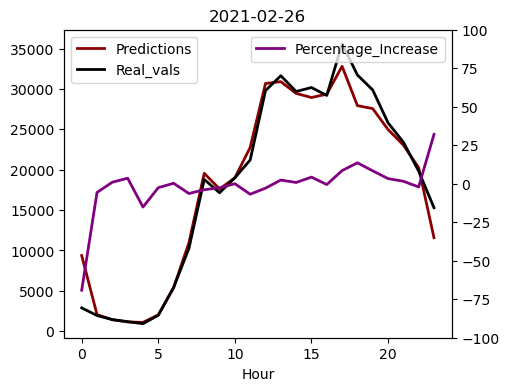

In [118]:
# Define the special date
special_date = '2021-02-26'
# Get data just from this date
special_dates_data = predictions_df[predictions_df['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()
# find overall error this day
special_dates_data['Real_vals'].sum()/special_dates_data['Predictions'].sum() * 100

def find_hourly_errors_on_date(special_dates_data, special_date):
    
    ### Aggregate data by hour (sum or mean)(and remove unneeded columns)
    # Find the sum each hour (across all sensors)
    special_date_hourly_values =special_dates_data.groupby(['Hour']).sum() #mean()
    # Remove extra columns
    special_date_hourly_values.drop(['Weekday', 'sensor_id', 'AbsolouteError', 'Error'], axis=1, inplace=True)
    
    ### Add error metrics
    special_date_hourly_values['AbsolouteError'] = abs(special_date_hourly_values['Real_vals']-special_date_hourly_values['Predictions'])
    special_date_hourly_values['Error'] = special_date_hourly_values['Real_vals']-special_date_hourly_values['Predictions']
    special_date_hourly_values['Percentage_Increase'] = ((special_date_hourly_values['Real_vals'] - special_date_hourly_values['Predictions']) / abs(special_date_hourly_values['Predictions'])) * 100
    special_date_hourly_values['Mape']  = special_date_hourly_values.apply(lambda x: MAPE(x['Real_vals'], x['Predictions']), axis=1)
    
    ### PLot
    fig, ax = plt.subplots(figsize = (5,4), sharex = True)
    ax2 = ax.twinx()
    special_date_hourly_values['Predictions'].plot(ax=ax, color='darkred', linewidth=2, legend =True)
    special_date_hourly_values['Real_vals'].plot(ax=ax, color='black', linewidth=2, legend =True)
    special_date_hourly_values['Percentage_Increase'].plot(ax=ax2, color='purple', linewidth=2, legend =True)
    ax2.set_ylim(-100,100);
    ax.set_title(special_date)
    plt.show()
    
find_hourly_errors_on_date(special_dates_data, special_date)    

### Plot the trajectory of the real values and the errors throughout the day
(Problem is that if the change on this day is concentrated at particular sensors then this might be hidden within)

In [115]:
# values_to_plot = ['Real_vals', 'Predictions', 'Error', 'Mape', 'Percentage_Increase']

# def plot_values (ax, value_to_plot):
#     anzac_day_hourly_values[value_to_plot].plot(ax=ax)
    
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (20,10), sharex = True)
# for number, ax in enumerate(axs.reshape(-1)): 
#     if number <5:
#         plot_values(ax, values_to_plot[number])
#         ax.xaxis.set_tick_params(labelsize='large')
#         ax.yaxis.set_tick_params(labelsize='large')
#         ax.set_title(values_to_plot[number], fontsize = 15)

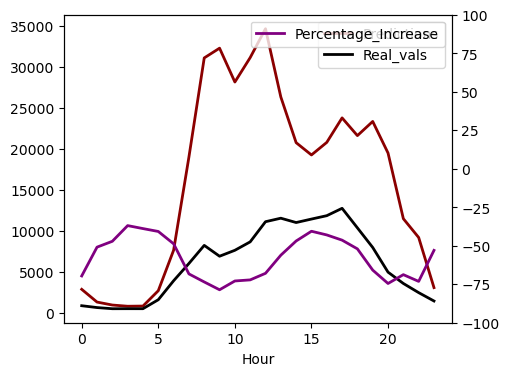

In [65]:
fig, ax = plt.subplots(figsize = (5,4), sharex = True)
ax2 = ax.twinx()
anzac_day_hourly_values['Predictions'].plot(ax=ax, color='darkred', linewidth=2, legend =True)
anzac_day_hourly_values['Real_vals'].plot(ax=ax, color='black', linewidth=2, legend =True)
anzac_day_hourly_values['Percentage_Increase'].plot(ax=ax2, color='purple', linewidth=2, legend =True)
ax2.set_ylim(-100,100);

## Find the errors for each sensors 

### Aggregate data by sensor (sum or mean)

In [104]:
anzac_day_sensorly_values =anzac_day.groupby(['sensor_id']).sum()
# Remove extra columns
anzac_day_sensorly_values.drop(['Weekday', 'Percentage_Increase', 'AbsolouteError', 'Error', 'Hour'], axis=1, inplace=True)

In [105]:
anzac_day_sensorly_values['AbsolouteError'] = abs(anzac_day_sensorly_values['Real_vals']-anzac_day_sensorly_values['Predictions'])
anzac_day_sensorly_values['Error'] = anzac_day_sensorly_values['Real_vals']-anzac_day_sensorly_values['Predictions']
anzac_day_sensorly_values['Percentage_Increase'] = ((anzac_day_sensorly_values['Real_vals'] - anzac_day_sensorly_values['Predictions']) / abs(anzac_day_sensorly_values['Predictions'])) * 100

### Join back with sensor geographic data

In [106]:
anzac_day_sensorly_values = pd.merge(anzac_day_sensorly_values, melbourne_sensors[['Latitude', 'Longitude', 'sensor_id']], on='sensor_id', how='left')
anzac_day_sensorly_values.head()

,sensor_id,Predictions,Real_vals,AbsolouteError,Error,Percentage_Increase,Latitude,Longitude
0,1,235543.23,198584,36959.23,-36959.23,-15.691060,-37.813494,144.965153
1,2,137426.62,119670,17756.62,-17756.62,-12.920801,-37.813807,144.965167
2,3,54759.92,45757,9002.92,-9002.92,-16.440711,-37.811015,144.964295
3,4,288428.65,256328,32100.65,-32100.65,-11.129494,-37.814880,144.966088
4,5,313988.33,286102,27886.33,-27886.33,-8.881327,-37.818742,144.967877


### Plot spatially the errors

In [108]:
error_metric = 'Percentage_Increase'
linear = cm.linear.viridis.scale(anzac_day_sensorly_values[error_metric].min(),anzac_day_sensorly_values[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in anzac_day_sensorly_values.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Percentage Increase"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

# img_data = melbourne_map._to_png(5)
# img = Image.open(io.BytesIO(img_data))
melbourne_map

In [109]:
error_metric = 'Real_vals'
linear = cm.linear.viridis.scale(anzac_day_sensorly_values[error_metric].min(),anzac_day_sensorly_values[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in anzac_day_sensorly_values.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = error_metric
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

# img_data = melbourne_map._to_png(5)
# img = Image.open(io.BytesIO(img_data))
melbourne_map


### Plot the hourly values for sensor 29 (which has the biggest change in overall values on this day)
Or 12 or 38 (next 2 biggest)

In [42]:
anzac_day_sensor_29 = anzac_day[anzac_day['sensor_id']==38]
anzac_day_sensor_29.sort_values(by='Percentage_Increase', ascending = False)

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Increase
763254,316.87,1806,6,7,38,1489.13,1489.13,2015-02-22 06:00:00,w7_h6,469.949822
763282,563.58,1727,7,7,38,1163.42,1163.42,2015-02-22 07:00:00,w7_h7,206.433869
763320,949.66,1158,8,7,38,208.34,208.34,2015-02-22 08:00:00,w7_h8,21.938378
763354,1350.32,1492,9,7,38,141.68,141.68,2015-02-22 09:00:00,w7_h9,10.492328
763710,2022.22,2231,20,7,38,208.78,208.78,2015-02-22 20:00:00,w7_h20,10.324297
763749,2166.85,2258,21,7,38,91.15,91.15,2015-02-22 21:00:00,w7_h21,4.206567


In [43]:
over_0 = anzac_day_sensor_29[anzac_day_sensor_29['Real_vals']>0]
over_0 = over_0[over_0['Predictions']>0]
over_0.nlargest(100, 'Percentage_Increase')
anzac_day_sensor_29.nlargest(100, 'Percentage_Increase')

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Increase
763254,316.87,1806,6,7,38,1489.13,1489.13,2015-02-22 06:00:00,w7_h6,469.949822
763282,563.58,1727,7,7,38,1163.42,1163.42,2015-02-22 07:00:00,w7_h7,206.433869
763320,949.66,1158,8,7,38,208.34,208.34,2015-02-22 08:00:00,w7_h8,21.938378
763354,1350.32,1492,9,7,38,141.68,141.68,2015-02-22 09:00:00,w7_h9,10.492328
763710,2022.22,2231,20,7,38,208.78,208.78,2015-02-22 20:00:00,w7_h20,10.324297
763749,2166.85,2258,21,7,38,91.15,91.15,2015-02-22 21:00:00,w7_h21,4.206567


In [44]:
# total_predicted = df_filtered['Predictions'].sum()
# total_reality = df_filtered['Real_vals'].sum()
# total_predicted

### Plot the difference for this date spatially

In [45]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df_filtered[df_filtered['Sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

NameError: name 'sensorly_mapes' is not defined

In [ ]:
error_metric = 'MAE'
linear = cm.linear.viridis.scale(melbourne_sensors[error_metric].min(),melbourne_sensors[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "MAE"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
# img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map

In [ ]:
error_metric = 'MAPE'
linear = cm.linear.viridis.scale(melbourne_sensors[error_metric].min(),melbourne_sensors[error_metric].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row[error_metric]), fill_color = linear(row[error_metric]),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "MAPE"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
# img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map